# K-Nearest Neighbor Lab





In [79]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split as tts
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
from scipy.stats import mode
import pandas as pd


## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [29]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    def __init__(self, columntype=None, weight_type='inverse_distance', K=3, eps=1e-10, normalize=False, algorithm='standard'): ## add parameters here
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.normalize = normalize
        self.algorithm = algorithm
        self.column_dicts = None
        self.K = K
        self.eps = eps
        
        
    def fit(self, data, labels):
        if self.columntype is not None:
            data = self.adjust_data(data)
        self.X = data
        self.normal_vals = {'max': data.max(axis=0), 'min': data.min(axis=0)}
        if self.normalize:
            self.X = self.normalize_data(self.X)
        self.y = labels
        self.m, self.n = data.shape
        return self
    
    def find_neighbors_no_weight(self, x):
        distances = np.linalg.norm(x-self.X, axis=1, ord=2)
        if self.algorithm == 'regression':
            return np.mean(self.y[distances.argsort()][:self.K])
        else:
            return mode(self.y[distances.argsort()][:self.K])[0][0]
    
    def find_neighbors_inverse(self, x):
        distances = np.linalg.norm(x-self.X, axis=1, ord=2) #euclidian
        distance_args = distances.argsort()[:self.K] 
        K_distances = distances[distance_args]
        K_neighbors = self.y[distance_args]
        if self.algorithm == 'regression':
            values = []
            weights = []
            for neighbor, distance in zip(K_neighbors, K_distances):
                w = 1 if distance < self.eps else 1 / distance**2
                weights.append(w)
                values.append(neighbor*w)
            return np.array(values).sum()/np.array(weights).sum()
        else:
            votes = {i: 0 for i in set(K_neighbors)}
            for neighbor, distance in zip(K_neighbors, K_distances):
                votes[neighbor] += 1 / (distance**2 + self.eps)
            return max(votes, key=votes.get)
    
    def normalize_data(self, X):
        X = (X - self.normal_vals['min'])/(self.normal_vals['max']- self.normal_vals['min'])
        return X
    
    def predict(self, data):
        if self.normalize:
            data = self.normalize_data(data)
        if self.weight_type == 'no_weight':
            return [self.find_neighbors_no_weight(data[i]) for i in range(len(data))]
        elif self.weight_type == "inverse_distance":
            return [self.find_neighbors_inverse(data[i]) for i in range(len(data))]

    def score(self, X, y):
        if self.columntype is not None:
            X = self.adjust_data(X)
        return np.mean(self.predict(X) == y)
    
    def MSE(self, X, y):
        return np.mean((self.predict(X) - np.array(y))**2)
    
    def create_dictionaries(self, data):
        self.column_dicts = []
        temp = data.T
        for row in range(len(temp)):
            dict_ = {}
            if self.columntype[row] == 'cat':
                for val in set(temp[row]):
                    dict_.update({val: np.mean(temp[row] == val)})
            self.column_dicts.append(dict_)
        
    def adjust_data(self, data):
        if self.column_dicts is None:
            self.create_dictionaries(data)
        df = pd.DataFrame(data, columns=[str(i) for i in range(len(self.columntype))])
        for i in range(len(self.columntype)):
            if self.columntype[i] == 'cat':
                df[str(i)] = df[str(i)].apply(lambda x: self.column_dicts[i][x] if x in list(self.column_dicts[i].keys()) else 0)
            else:
                df[str(i)] = df[str(i)].apply(lambda x: 1 if x == b'?' else x)
        return df.values
        
    

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

Debug your model by running it on the [seismic bumps](https://archive.ics.uci.edu/ml/datasets/seismic-bumps) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_test.arff)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Acc = [93.57]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/seismic-bump-prediction.csv)


In [80]:
# Load seismic bumps data
data = pd.DataFrame(arff.loadarff('datasets/seismic-bumps_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('datasets/seismic-bumps_test.arff')[0], dtype=float)
x_train = data.drop(columns='Class').values
y_train = data['Class'].values
x_test = test.drop(columns='Class').values
y_test = test['Class'].values
knn = KNNClassifier()
results = knn.fit(x_train, y_train).score(x_test, y_test)
print(results*100)


93.57142857142857


### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff)

In [81]:
data = pd.DataFrame(arff.loadarff('datasets/diabetes_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('datasets/diabetes_test.arff')[0], dtype=float)
x_train = data.drop(columns='class').values
y_train = data['class'].values
x_test = test.drop(columns='class').values
y_test = test['class'].values
knn = KNNClassifier()
results = knn.fit(x_train, y_train).score(x_test, y_test)
print(results*100)


89.0625


## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1
- Try it with k=3 and without normalization


In [82]:
data = pd.DataFrame(arff.loadarff('datasets/magic_telescope_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('datasets/magic_telescope_test.arff')[0], dtype=float)
x_train = data.drop(columns='class').values
y_train = data['class'].values
x_test = test.drop(columns='class').values
y_test = test['class'].values
knn = KNNClassifier(weight_type='no_weight')
results = knn.fit(x_train, y_train).score(x_test, y_test)
print(results*100)


80.82808280828083


### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [31]:
# Train/Predict with normalization
data = pd.DataFrame(arff.loadarff('datasets/magic_telescope_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('datasets/magic_telescope_test.arff')[0], dtype=float)
x_train = data.drop(columns='class').values
y_train = data['class'].values
x_test = test.drop(columns='class').values
y_test = test['class'].values
knn = KNNClassifier(normalize=True, weight_type='no_weight')
results = knn.fit(x_train, y_train).score(x_test, y_test)
print(results*100)

83.06330633063307


Normalized Data gave back a higher accuracy.

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

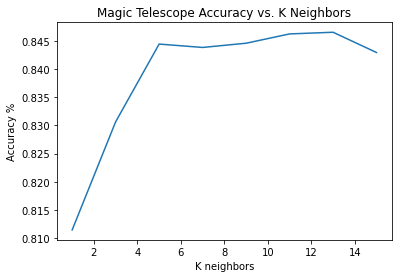

In [39]:
# Train/Predict with normalization using k=1,3,...,15
data = pd.DataFrame(arff.loadarff('datasets/magic_telescope_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('datasets/magic_telescope_test.arff')[0], dtype=float)
x_train = data.drop(columns='class').values
y_train = data['class'].values
x_test = test.drop(columns='class').values
y_test = test['class'].values
scores = []
vals = []
for k in np.arange(1, 16, 2):
    knn = KNNClassifier(K=k, normalize=True, weight_type='no_weight')
    knn.fit(x_train, y_train)
    vals.append(k)
    scores.append(knn.score(x_test, y_test))
fig = plt.figure()
plt.plot(vals, scores)
plt.title("Magic Telescope Accuracy vs. K Neighbors")
plt.ylabel("Accuracy %")
plt.xlabel("K neighbors")
plt.show()

# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


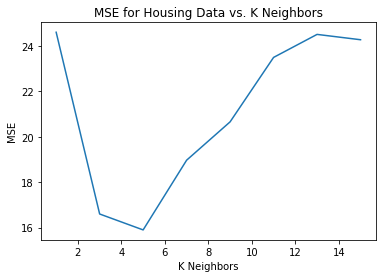

In [77]:
data = pd.DataFrame(arff.loadarff('datasets/housing_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('datasets/housing_test.arff')[0], dtype=float)
x_train = data.drop(columns='MEDV').values
y_train = data['MEDV'].values
x_test = test.drop(columns='MEDV').values
y_test = test['MEDV'].values
MSEs = []
vals = []
for k in np.arange(1, 16, 2):
    knn = KNNClassifier(K=k, normalize=True, weight_type='no_weight', algorithm='regression')
    knn.fit(x_train, y_train)
    vals.append(k)
    MSEs.append(knn.MSE(x_test, y_test))
fig = plt.figure()
plt.plot(vals, MSEs)
plt.title("MSE for Housing Data vs. K Neighbors")
plt.ylabel("MSE")
plt.xlabel("K Neighbors")
plt.show()


## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


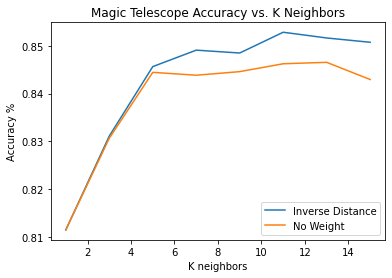

In [40]:
# Train/Predict magic telescope using distance-weighted voting
data = pd.DataFrame(arff.loadarff('datasets/magic_telescope_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('datasets/magic_telescope_test.arff')[0], dtype=float)
x_train = data.drop(columns='class').values
y_train = data['class'].values
x_test = test.drop(columns='class').values
y_test = test['class'].values
scores1 = []
vals = []
for k in np.arange(1, 16, 2):
    knn = KNNClassifier(K=k, normalize=True)
    knn.fit(x_train, y_train)
    vals.append(k)
    scores1.append(knn.score(x_test, y_test))
fig = plt.figure()
plt.plot(vals, scores1, label="Inverse Distance")
plt.plot(vals, scores, label="No Weight")
plt.title("Magic Telescope Accuracy vs. K Neighbors")
plt.ylabel("Accuracy %")
plt.xlabel("K neighbors")
plt.legend()
plt.show()

# Train/Predict housing using distance-weighted voting



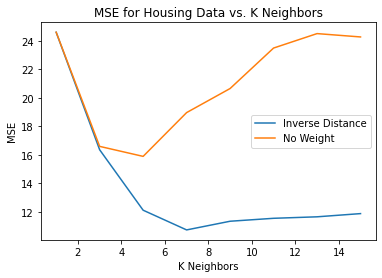

In [78]:
data = pd.DataFrame(arff.loadarff('datasets/housing_train.arff')[0], dtype=float)
test = pd.DataFrame(arff.loadarff('datasets/housing_test.arff')[0], dtype=float)
x_train = data.drop(columns='MEDV').values
y_train = data['MEDV'].values
x_test = test.drop(columns='MEDV').values
y_test = test['MEDV'].values
MSEs1 = []
vals = []
for k in np.arange(1, 16, 2):
    knn = KNNClassifier(K=k, normalize=True, algorithm='regression')
    knn.fit(x_train, y_train)
    vals.append(k)
    MSEs1.append(knn.MSE(x_test, y_test))
fig = plt.figure()
plt.plot(vals, MSEs1, label='Inverse Distance')
plt.plot(vals, MSEs, label="No Weight")
plt.title("MSE for Housing Data vs. K Neighbors")
plt.ylabel("MSE")
plt.xlabel("K Neighbors")
plt.legend()
plt.show()

In both cases Inverse Distance weighting provide much better accuracy and mean squared errors for both datasets than compared to no weights. Both seem to diverge in performance when using more than 3 neighbors.

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [75]:
data = pd.DataFrame(arff.loadarff('datasets/credit_approval.arff')[0], dtype=float)
data['class'] = data['class'].map({b'+':0, b'-':1})
col_types = ['cat', 'num', 'num', 'cat', 'cat', 'cat', 'cat', 'num', 'cat', 'cat', 'num', 'cat', 'cat', 'num', 'num']
X_train, X_test = tts(data)
y_train = X_train['class'].values
X_train = X_train.drop(columns=['class']).values
y_test = X_test['class'].values
X_test = X_test.drop(columns=['class']).values
knn = KNNClassifier(K=7, columntype=col_types, normalize=False)
results = knn.fit(X_train, y_train).score(X_test, y_test)
print(results*100)


71.09826589595376


*Explain and justify your distance metric*

## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


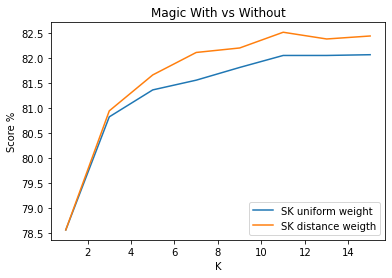

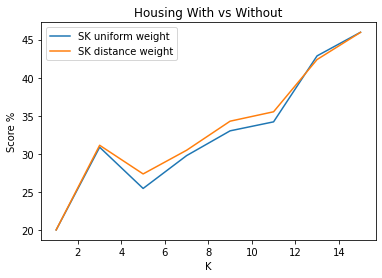

In [76]:
# Train/Predict magic telescope using distance-weighted voting
train = pd.DataFrame(arff.loadarff('datasets/magic_telescope_train.arff')[0], dtype=float)
X_train = train.drop(columns='class').values
y_train = train['class'].map({b'g':0, b'h':1}).values
test =  pd.DataFrame(arff.loadarff('datasets/magic_telescope_test.arff')[0], dtype=float)
X_test = test.drop(columns='class').values
y_test = test['class'].map({b'g':0, b'h':1}).values

m_scores_with = []
m_scores_without = []
for k in np.arange(1,16,2):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    m_scores_without.append(knn.score(X_test, y_test)*100)

    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    m_scores_with.append(knn.score(X_test, y_test)*100)

plt.plot(np.arange(1,16,2), m_scores_with, label='SK uniform weight')
plt.plot(np.arange(1,16,2), m_scores_without, label='SK distance weigth')
plt.title("Magic With vs Without")
plt.xlabel("K")
plt.ylabel("Score %")
plt.legend()
plt.show()


# Load housing price prediction data
train = pd.DataFrame(arff.loadarff('datasets/housing_train.arff')[0], dtype=float)
X_train = train.drop(columns='MEDV').values
y_train = train['MEDV'].values
test =  pd.DataFrame(arff.loadarff('datasets/housing_test.arff')[0], dtype=float)
X_test = test.drop(columns='MEDV').values
y_test = test['MEDV'].values
h_scores_with = []
h_scores_without = []
for k in np.arange(1,16,2):
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    h_scores_without.append(knn.score(X_test, y_test)*100)

    knn = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    h_scores_with.append(knn.score(X_test, y_test)*100)

plt.plot(np.arange(1,16,2), h_scores_with, label='SK uniform weight')
plt.plot(np.arange(1,16,2), h_scores_without, label='SK distance weight')
plt.title("Housing With vs Without")
plt.xlabel("K")
plt.ylabel("Score %")
plt.legend()
plt.show()

It seems that distance weighting with the classifier seems to behave similarly to my own classifier and more than three neighbors provides significant improvement in accuracy. However there seems to be some improvement in the sk knn regression between 5 and 11 neighbors for distance weighting, but performs roughly similar to uniform once the neighbors are larger than 13. 

## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).
